In [1]:
import copy
import pickle
import inspect
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from rich import progress
from scipy import constants

from centrex_tlf import hamiltonian, states
from centrex_trajectories import (
    Coordinates,
    Gravity,
    PropagationOptions,
    PropagationType,
    Velocities,
    propagate_trajectories,
)
from centrex_trajectories.beamline_objects import (
    Bore,
    CircularAperture,
    ElectrostaticLensPolynomial,
    ElectrostaticQuadrupoleLens,
    RectangularAperture,
    Section,
)
from centrex_trajectories.particles import TlF
from centrex_trajectories.utils import (
    double_richards_symmetric,
    fit_stark_potential,
)
from centrex_trajectories.polynomials import Polynomial2D
from centrex_trajectories.visualization import plot_beamline
from eigenshuffle import eigenshuffle_eigh


In [2]:
plt.rcParams.update({"font.size": 14})


In [3]:
class TaskSpeed(progress.ProgressColumn):
    def render(self, task):
        if task.speed is None:
            return ""
        elif task.speed >= 0.1:
            return f"{(task.speed or 0):.1f}/s"
        else:
            return f"{(1 / task.speed or 0):.1f} s/i"


# Setup
## Generate Stark Potentials

In [4]:
# generate states up to J=6
QN = states.generate_uncoupled_states_ground(Js=np.arange(7))

# generate the X hamiltonian terms
H = hamiltonian.generate_uncoupled_hamiltonian_X(QN)

# create a function outputting the hamiltonian as a function of E and B
Hfunc = hamiltonian.generate_uncoupled_hamiltonian_X_function(H)

# V/cm
Ez = np.linspace(0, 50e3, 2_001)

# generate the Hamiltonian for (almost) zero field, add a small field to make states
# non-degenerate
Hi = Hfunc(E=[0, 0, 1e-3], B=[0, 0, 1e-3])
E, V = np.linalg.eigh(Hi)

# run eigenshuffle to track the states
Ez = np.append(np.linspace(0, 1_000, 501), np.linspace(2_000, 50_000, 51))
hamiltonians = np.array([Hfunc(E=[0, 0, Ei], B=[0, 0, 1e-3]) for Ei in Ez])
es, vs = eigenshuffle_eigh(hamiltonians)

# get the true superposition-states of the system
QN_states = hamiltonian.matrix_to_states(vs[0], QN)


In [5]:
indices_J2 = [idx for idx, s in enumerate(QN_states) if s.largest.J == 2]

indices_J2_F3 = (
    indices_J2[0]
    + np.where(
        [
            qn.largest.F == 3
            for qn in [
                qn.remove_small_components().transform_to_coupled()
                for qn in np.array(QN_states)[indices_J2]
            ]
        ]
    )[0]
)
indices_J2_other = [idx for idx in indices_J2 if idx not in indices_J2_F3]

indices_J2_mF0 = (
    indices_J2[0]
    + np.where(
        [
            qn.largest.mF == 0 and qn.largest.F == 3
            for qn in [
                qn.remove_small_components().transform_to_coupled()
                for qn in np.array(QN_states)[indices_J2]
            ]
        ]
    )[0]
)

indices_J2_mF2 = (
    indices_J2[0]
    + np.where(
        [
            qn.largest.mF == 2 and qn.largest.F == 3
            for qn in [
                qn.remove_small_components().transform_to_coupled()
                for qn in np.array(QN_states)[indices_J2]
            ]
        ]
    )[0]
)

indices_J2_mF3 = (
    indices_J2[0]
    + np.where(
        [
            qn.largest.mF == 3
            for qn in [
                qn.remove_small_components().transform_to_coupled()
                for qn in np.array(QN_states)[indices_J2]
            ]
        ]
    )[0]
)


In [6]:
# convert to V/m
Ez_Vm = Ez * 100

# grab energy of J=2, mF=0, 2 & 3
# mF=-1,0,1 have more or less the same energy levels, just slight differences at higher
# fields
energy = es.real[:, indices_J2_mF0[0]] * constants.hbar
fit_coeff_mF0 = fit_stark_potential(Ez_Vm, energy, deg=11)

energy = es.real[:, indices_J2_mF2[0]] * constants.hbar
fit_coeff_mF2 = fit_stark_potential(Ez_Vm, energy, deg=11)

energy = es.real[:, indices_J2_mF3[0]] * constants.hbar
fit_coeff_mF3 = fit_stark_potential(Ez_Vm, energy, deg=11)


## Beamline Setup

In [7]:
options = PropagationOptions(verbose=False, n_cores=8)
particle = TlF()
gravity = Gravity(0, -9.81 * particle.mass, 0)

# EQL parameters
L = 0.6
R = 1.75 * 25.4e-3 / 2
V = 28_000


# DET parameters current aperture
wx = 13e-3
wy = 3e-3

# conversion factors
in_to_m = 25.4e-3

n_nipples = 3

# beamline lengths
distance_lens_bbexit = 36 * in_to_m
lens_chamber_length = (24 + 5 / 8) * in_to_m
lens_reducer_flange = (7 / 8 + 3 + 1 / 8) * in_to_m
lens_electrode_length = L  # m
nipple_length = 39 * in_to_m
distance_det_center = 5.25 * in_to_m
lens_reducer_flange = (3 + 1 / 8 + 7 / 8) * in_to_m
bs_flange = 3 / 4 * in_to_m
rc_chamber_length_no_flanges = 10.5 * in_to_m
rc_chamber_center_from_bs_front = (16 + 3 / 8) * in_to_m
rc_aperture_from_center = 3.56 * in_to_m
rc_aperture_radius = 0.011


# acme freezing distribution modified to our cell opening size (0.25" vs 5 mm for ACME)
sigma_x = 0.25 * 25.4 / 5 * 3.8e-3  # Sigma for the gaussian position distribution
sigma_y = 0.25 * 25.4 / 5 * 3.8e-3  # Sigma for the gaussian position distribution


In [8]:
potential_xy_coefficients = np.array(
    [
        [
            0.00000000e00,
            0.00000000e00,
            -1.85807316e-03,
            -3.68838654e-01,
            9.05179603e01,
            5.02802652e02,
            -2.33774653e05,
        ],
        [
            0.00000000e00,
            -4.01516882e03,
            -4.57787118e-02,
            -8.53726662e03,
            -9.44499189e03,
            5.34213172e08,
            2.04894221e07,
        ],
        [
            1.55556469e-02,
            -1.08269983e01,
            4.98195718e02,
            1.21401040e05,
            -6.62042908e06,
            -2.00043668e08,
            1.63384388e10,
        ],
        [
            4.95047018e-01,
            -8.94339785e03,
            1.44796476e04,
            -1.69855041e09,
            -6.86084354e07,
            -6.47064425e09,
            -2.57901217e04,
        ],
        [
            -1.83341406e02,
            4.73566410e04,
            2.21617329e06,
            -3.02270553e08,
            -7.46259863e09,
            -1.14022371e05,
            -3.74750620e05,
        ],
        [
            -1.83757741e03,
            5.34389645e08,
            -1.65987718e07,
            6.46968544e09,
            -2.13239592e04,
            -1.31548209e02,
            -7.07835673e00,
        ],
        [
            2.78503072e05,
            -4.15374780e07,
            -1.08606156e09,
            -1.22530620e05,
            -2.91966193e06,
            -3.60532824e01,
            -5.51716726e02,
        ],
    ]
)

args_double_richards = [
    [np.float64(-0.2772285477882198), np.float64(0.2772285477882198)],
    0.0,
    1.0,
    np.float64(0.17549989486349324),
    np.float64(199.16917527732758),
    np.float64(3.3589614392622846),
]

signature = inspect.signature(double_richards_symmetric)
arg_names = [param.name for param in signature.parameters.values()]

potential_z = partial(
    double_richards_symmetric,
    **dict([(name, arg) for name, arg in zip(arg_names[1:], args_double_richards)]),
)

## Beamline Sections

| What | Length |
| --- | --- |  
| bs flange | 3/4" |
| center of the RC chamber to the beamsource front | 16-3/8" |
| center of the SPA chamber to the beamsource front | 28-3/8" |
| front of the EQL chamber to the beamsource front | 36" |
| lens chamber length | 24-5/8" |
| lens electrode length | 0.6 m |
| lens flange with o-ring | 7/8" |
| lens reducer | 3-1/8" |
| center of DET to start chamber | 5-1/4" |
| long nipple length | 39" |
| rc chamber length without flanges | 10.5" |
| rc chamber front without flanges to front bs flange | 10-3/8" |
| rc aperture from center rc | 3.56" | 
| rc aperture radius | 0.011 m |

In [9]:
fourK = Section(
    name="4K shield",
    objects=[CircularAperture(0, 0, 1.75 * in_to_m, in_to_m / 2)],
    start=0,
    stop=(1.75 + 0.25) * 0.0254,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)
fourtyK = Section(
    name="40K shield",
    objects=[CircularAperture(0, 0, fourK.stop + 1.25 * in_to_m, in_to_m / 2)],
    start=fourK.stop,
    stop=fourK.stop + (1.25 + 0.25) * 0.0254,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)
bbexit = Section(
    name="Beamsource Exit",
    objects=[CircularAperture(0, 0, fourtyK.stop + 2.5 * in_to_m, 2 * in_to_m)],
    start=fourtyK.stop,
    stop=fourtyK.stop + (2.5 + 0.75) * in_to_m,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)

rc = Section(
    name="Rotational cooling",
    objects=[
        CircularAperture(
            x=0,
            y=0,
            z=bbexit.stop + rc_chamber_center_from_bs_front + rc_aperture_from_center,
            r=rc_aperture_radius,
        )
    ],
    start=bbexit.stop
    + bs_flange
    + rc_chamber_center_from_bs_front
    - rc_chamber_length_no_flanges / 2,
    stop=bbexit.stop
    + rc_chamber_center_from_bs_front
    + rc_chamber_length_no_flanges / 2,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)

spa = Section(
    name="State Prep A",
    objects=[],
    start=bbexit.stop,
    stop=bbexit.stop + (19.6 + 0.375 + 9.625 + 0.375) * in_to_m,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)
lens_start = (
    bbexit.stop
    + distance_lens_bbexit
    + (lens_chamber_length - lens_electrode_length) / 2
)

lens_stop = (
    bbexit.stop
    + distance_lens_bbexit
    + lens_chamber_length
    - (lens_chamber_length - lens_electrode_length) / 2
)

lens_middle = (lens_start + lens_stop) / 2

eql = ElectrostaticLensPolynomial(
    name="Electrostatic Lens",
    objects=[
        Bore(
            x=0,
            y=0,
            z=bbexit.stop
            + distance_lens_bbexit
            + (lens_chamber_length - lens_electrode_length) / 2,
            length=lens_electrode_length,
            radius=R,
        )
    ],
    start=lens_start,
    stop=lens_stop,
    V=V,
    R=R,
    save_collisions=True,
    potential_xy=Polynomial2D(kx=6, ky=6, coeffs=potential_xy_coefficients),
    potential_z=lambda z: potential_z(z - lens_middle),
)
det = Section(
    name="Detection",
    objects=[
        RectangularAperture(
            0,
            0,
            eql.stop
            + lens_reducer_flange
            + n_nipples * nipple_length
            + +10.5 * in_to_m
            + distance_det_center
            + 0.001,
            wx,
            wy,
        )
    ],
    start=eql.stop
    + lens_reducer_flange
    + n_nipples * nipple_length
    + 10.5 * in_to_m
    + distance_det_center,
    stop=eql.stop
    + lens_reducer_flange
    + n_nipples * nipple_length
    + 10.5 * in_to_m
    + distance_det_center
    + 1e-2,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
    force=None,
)


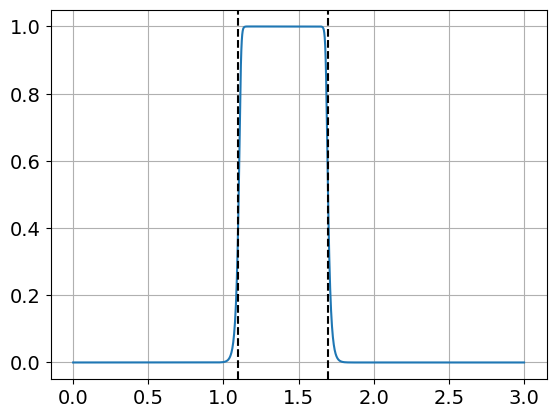

In [10]:
z = np.linspace(0, 3, 1001)
fig, ax = plt.subplots()
ax.plot(z, eql.potential_z(z))
ax.axvline(eql.start, color="k", linestyle="--")
ax.axvline(eql.stop, color="k", linestyle="--")
ax.grid()

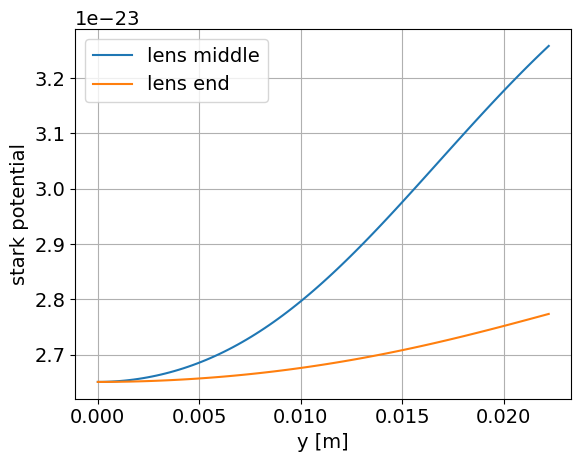

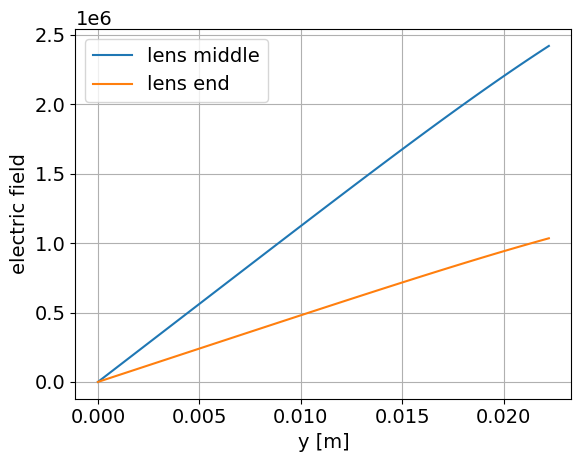

In [11]:
_r = np.linspace(0, R, 101)

fig, ax = plt.subplots()
ax.plot(
    _r,
    eql.stark_potential(np.zeros(_r.shape), _r, np.ones(_r.shape) * lens_middle),
    label="lens middle",
)
ax.plot(
    _r,
    eql.stark_potential(np.zeros(_r.shape), _r, np.ones(_r.shape) * eql.stop),
    label="lens end",
)

ax.set_ylabel("stark potential")
ax.set_xlabel("y [m]")
ax.legend()

ax.grid(True)

fig, ax = plt.subplots()

ax.plot(
    _r,
    np.linalg.norm(
        eql.electric_field(np.zeros(_r.shape), _r, np.ones(_r.shape) * lens_middle),
        axis=0,
    ),
    label="lens middle",
)
ax.plot(
    _r,
    np.linalg.norm(
        eql.electric_field(np.zeros(_r.shape), _r, np.ones(_r.shape) * eql.stop),
        axis=0,
    ),
    label="lens end",
)

ax.set_ylabel("electric field")
ax.set_xlabel("y [m]")
ax.legend()

ax.grid(True)

In [12]:
%%timeit
eql.force(0.0, 0.0, 0.0, lens_middle)

The slowest run took 5.69 times longer than the fastest. This could mean that an intermediate result is being cached.
19.4 µs ± 17.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%%timeit
eql.potential_xy.evaluate(0.0, 0.0)

611 ns ± 6.15 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [14]:
def run_many():
    for _ in range(100_000):
        eql.force(0.0, 0.0, 0.0, lens_middle)

In [15]:
%prun run_many()

         3700098 function calls in 2.198 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   100000    0.625    0.000    2.156    0.000 beamline_objects.py:614(force)
   600000    0.576    0.000    0.687    0.000 polynomials.py:406(evaluate)
   100000    0.243    0.000    0.327    0.000 polynomials.py:38(__call__)
   100000    0.180    0.000    0.195    0.000 utils.py:87(double_richards_symmetric)
   600000    0.175    0.000    0.862    0.000 polynomials.py:121(__call__)
  1500007    0.165    0.000    0.165    0.000 {built-in method builtins.isinstance}
   100000    0.077    0.000    0.272    0.000 1211288230.py:89(<lambda>)
        1    0.042    0.042    1.999    1.999 3739925573.py:1(run_many)
   100000    0.031    0.000    0.031    0.000 {method 'tolist' of 'numpy.ndarray' objects}
   100000    0.026    0.000    0.038    0.000 numeric.py:1927(isscalar)
   100000    0.016    0.000    0.016    0.000 beamline_objects.py:220(

In [16]:
def lens_scan_function(
    origin: Coordinates,
    velocities: Velocities,
    voltage: float,
    detection_laser_distance: float,
    detection_aperture_distance: float,
    length: float = 0.6,
    radius: float = 0.022225,
    stark_potential: npt.NDArray[np.float64] = fit_coeff_mF0,
    ideal_lens: bool = False,
):
    lens_start = bbexit.stop + distance_lens_bbexit + (lens_chamber_length - length) / 2
    lens_stop = lens_start + length
    lens_middle = (lens_start + lens_stop) / 2

    if voltage == 0:
        eql = Section(
            name="Electrostatic Lens",
            objects=[
                Bore(
                    x=0,
                    y=0,
                    z=lens_start,
                    length=length,
                    radius=radius,
                )
            ],
            start=lens_start,
            stop=lens_stop,
            save_collisions=False,
        )
    else:
        if ideal_lens:
            eql = ElectrostaticQuadrupoleLens(
                name="Electrostatic Lens",
                objects=[Bore(x=0, y=0, z=lens_start, length=length, radius=radius)],
                start=lens_start,
                stop=lens_stop,
                V=voltage,
                R=radius,
                save_collisions=False,
                stark_potential=stark_potential,
            )
        else:
            eql = ElectrostaticLensPolynomial(
                name="Electrostatic Lens",
                objects=[
                    Bore(
                        x=0,
                        y=0,
                        z=lens_start,
                        length=length,
                        radius=radius,
                    )
                ],
                start=lens_start,
                stop=lens_stop,
                V=voltage,
                R=radius,
                save_collisions=False,
                stark_potential=stark_potential,
                potential_xy=Polynomial2D(kx=6, ky=6, coeffs=potential_xy_coefficients),
                potential_z=lambda z: potential_z(z - lens_middle),
            )

    det = Section(
        name="Detection",
        objects=[
            RectangularAperture(
                0,
                0,
                eql.stop + detection_aperture_distance,
                wx,
                wy,
            )
        ],
        start=eql.stop + detection_aperture_distance - 1e-3,
        stop=eql.stop + detection_laser_distance,
        save_collisions=False,
        propagation_type=PropagationType.ballistic,
        force=None,
    )

    sections = [fourK, fourtyK, bbexit, rc, spa, eql, det]
    section_data, trajectories = propagate_trajectories(
        sections,
        origin,
        velocities,
        particle,
        force=gravity,
        options=options,
    )
    return section_data, trajectories, sections


## Initialize distribution

In [17]:
n_trajectories = 40_000_000

origin = Coordinates(
    x=np.random.randn(n_trajectories) * sigma_x,
    y=np.random.randn(n_trajectories) * sigma_y,
    z=np.zeros(n_trajectories),
)
velocities = Velocities(
    vx=np.random.randn(n_trajectories) * 39.4,
    vy=np.random.randn(n_trajectories) * 39.4,
    vz=np.random.randn(n_trajectories) * 16 + 184,
)


# Scan

In [18]:
voltages = (
    np.array(
        [0.0, 10.0, 15.0, 20.0, 21.25, 22.5, 23.75, 25.0, 26.25, 27.5, 28.75, 30.0]
    )
    * 1e3
)

data = {"mF=0": [], "mF=2": [], "mF=3": []}

with progress.Progress(
    progress.TextColumn("[progress.description]{task.description}"),
    progress.BarColumn(),
    progress.TaskProgressColumn(),
    progress.MofNCompleteColumn(),
    progress.TimeElapsedColumn(),
    progress.TimeRemainingColumn(),
) as pb:
    t2 = pb.add_task("mF", total=3)
    t3 = pb.add_task("voltage", total=len(voltages))
    for idx, (mf, stark_coeff) in enumerate(
        zip(["mF=0", "mF=2", "mF=3"], [fit_coeff_mF0, fit_coeff_mF2, fit_coeff_mF3])
    ):
        for idy, voltage in enumerate(voltages):
            data[mf].append(
                lens_scan_function(
                    origin,
                    velocities,
                    voltage,
                    detection_laser_distance=lens_reducer_flange
                    + n_nipples * nipple_length
                    + 10.5 * in_to_m
                    + distance_det_center,
                    detection_aperture_distance=lens_reducer_flange
                    + n_nipples * nipple_length
                    + distance_det_center
                    + 10.5 * in_to_m
                    - 1 * in_to_m,
                    length=lens_electrode_length,
                    stark_potential=stark_coeff,
                )
            )
            pb.update(task_id=t3, completed=idy + 1, refresh=True)
        pb.update(task_id=t2, completed=idx + 1, refresh=True)
        pb.refresh()


Output()

In [19]:
voltages = (
    np.array(
        [0.0, 10.0, 15.0, 20.0, 21.25, 22.5, 23.75, 25.0, 26.25, 27.5, 28.75, 30.0]
    )
    * 1e3
)

data_ideal = {"mF=0": [], "mF=2": [], "mF=3": []}

with progress.Progress(
    progress.TextColumn("[progress.description]{task.description}"),
    progress.BarColumn(),
    progress.TaskProgressColumn(),
    progress.MofNCompleteColumn(),
    progress.TimeElapsedColumn(),
    progress.TimeRemainingColumn(),
) as pb:
    t2 = pb.add_task("mF", total=3)
    t3 = pb.add_task("voltage", total=len(voltages))
    for idx, (mf, stark_coeff) in enumerate(
        zip(["mF=0", "mF=2", "mF=3"], [fit_coeff_mF0, fit_coeff_mF2, fit_coeff_mF3])
    ):
        for idy, voltage in enumerate(voltages):
            data_ideal[mf].append(
                lens_scan_function(
                    origin,
                    velocities,
                    voltage,
                    detection_laser_distance=lens_reducer_flange
                    + n_nipples * nipple_length
                    + 10.5 * in_to_m
                    + distance_det_center,
                    detection_aperture_distance=lens_reducer_flange
                    + n_nipples * nipple_length
                    + distance_det_center
                    + 10.5 * in_to_m
                    - 1 * in_to_m,
                    length=lens_electrode_length,
                    stark_potential=stark_coeff,
                    ideal_lens=True,
                )
            )
            pb.update(task_id=t3, completed=idy + 1, refresh=True)
        pb.update(task_id=t2, completed=idx + 1, refresh=True)
        pb.refresh()


Output()

In [20]:
from centrex_tlf.utils import population

In [ ]:
temperature = 6.3
rc_efficiency = 0.8
thermal_population = population.thermal_population(np.arange(4), temperature)

survived = {
    "mF=0": np.array([], dtype=np.int64),
    "mF=2": np.array([], dtype=np.int64),
    "mF=3": np.array([], dtype=np.int64),
}
survived_error = {
    "mF=0": np.array([], dtype=np.float64),
    "mF=2": np.array([], dtype=np.float64),
    "mF=3": np.array([], dtype=np.float64),
}
survived_ideal = {
    "mF=0": np.array([], dtype=np.int64),
    "mF=2": np.array([], dtype=np.int64),
    "mF=3": np.array([], dtype=np.int64),
}
survived_ideal_error = {
    "mF=0": np.array([], dtype=np.float64),
    "mF=2": np.array([], dtype=np.float64),
    "mF=3": np.array([], dtype=np.float64),
}
for mf in ["mF=0", "mF=2", "mF=3"]:
    survived[mf] = np.array([len(d[1]) for d in data[mf]])
    survived_ideal[mf] = np.array([len(d[1]) for d in data_ideal[mf]])
    survived_error[mf] = np.sqrt(survived[mf])
    survived_ideal_error[mf] = np.sqrt(survived_ideal[mf])


In [ ]:
print(survived)
print(survived_ideal)

{'mF=0': array([ 215,  272,  483, 1236, 1646, 1991, 2391, 2621, 2696, 2590, 2388,
       2183]), 'mF=2': array([215, 233, 268, 334, 371, 389, 408, 426, 428, 464, 474, 470]), 'mF=3': array([215, 160, 105,  75,  78,  71,  64,  54,  51,  49,  43,  37])}
{'mF=0': array([ 215,  281,  511, 1380, 1805, 2159, 2583, 2731, 2730, 2567, 2349,
       2048]), 'mF=2': array([215, 234, 281, 354, 383, 398, 411, 428, 448, 468, 481, 482]), 'mF=3': array([215, 156,  98,  76,  72,  67,  61,  52,  49,  45,  40,  31])}


In [33]:
rc_population = (
    3 / 4 * thermal_population[0] + rc_efficiency * thermal_population[1:].sum()
)

In [51]:
J2_levels = population.J_levels(2)

survived_avg = (
    survived["mF=0"] * rc_population
    + survived["mF=2"] * (1 - rc_efficiency) * thermal_population[2] * 2 / J2_levels
    + survived["mF=3"] * (1 - rc_efficiency) * thermal_population[2] * 2 / J2_levels
)

survived_ideal_avg = (
    survived_ideal["mF=0"] * rc_population
    + survived_ideal["mF=2"]
    * (1 - rc_efficiency)
    * thermal_population[2]
    * 2
    / J2_levels
    + survived_ideal["mF=3"]
    * (1 - rc_efficiency)
    * thermal_population[2]
    * 2
    / J2_levels
)


gains = survived_avg / survived_avg[0]
gains_error = gains * np.sqrt(1 / survived_avg + 1 / survived_avg[0])

gains_ideal = survived_ideal_avg / survived_ideal_avg[0]
gains_error_ideal = gains_ideal * np.sqrt(
    1 / survived_ideal_avg + 1 / survived_ideal_avg[0]
)

In [ ]:
print(survived_avg)
print(survived_ideal_avg)

[  97.2629992   122.49303913  216.31910136  551.55342187  734.15982977
  887.73301519 1065.78610759 1168.17068579 1201.54367449 1154.49649746
 1064.61672555  973.35034044]
[  97.2629992   126.48719395  228.80181635  615.71394896  804.94046272
  962.51516672 1151.23038429 1217.12313598 1216.74070574 1144.26098515
 1047.27558438  913.29442469]


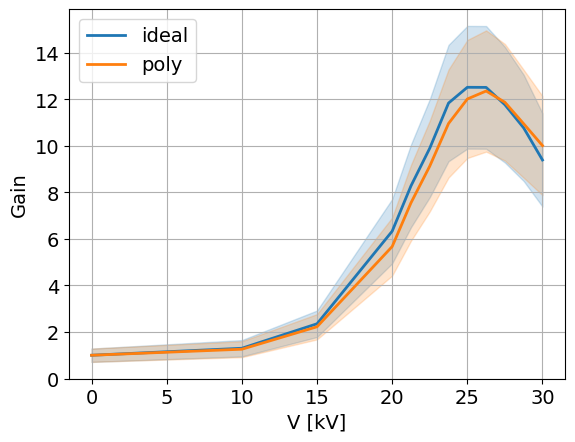

In [52]:
fig, ax = plt.subplots()

(l_ideal,) = ax.plot(voltages / 1e3, gains_ideal, lw=2, label="ideal")
ax.fill_between(
    voltages / 1e3,
    gains_ideal - 2 * gains_error_ideal,
    gains_ideal + 2 * gains_error_ideal,
    alpha=0.2,
    edgecolor=l_ideal.get_color(),
    facecolor=l_ideal.get_color(),
)

(l,) = ax.plot(voltages / 1e3, gains, lw=2, label="poly")
ax.fill_between(
    voltages / 1e3,
    gains - 2 * gains_error,
    gains + 2 * gains_error,
    alpha=0.2,
    edgecolor=l.get_color(),
    facecolor=l.get_color(),
)

ax.set_xlabel("V [kV]")
ax.set_ylabel("Gain")
ax.legend()
ax.grid()